In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных
file_path = "MainDF.csv"  # Укажите путь к вашему CSV-файлу
df = pd.read_csv(file_path, na_values=[''])

In [ ]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей

# Выбираем только финансовые показатели
financial_data = df.iloc[:, start_col:end_col]

In [ ]:
# Устанавливаем порог пропусков
threshold_years = 2  # Минимум в 4 годах есть пропуски
threshold_indicators = 10  # Минимум 6 финансовых показателей с пропусками

# Функция для определения первого года, с которого начинаем учитывать пропуски
def get_start_year(group):
    non_empty_years = group.loc[group["Технология"].notna(), "year"]
    return non_empty_years.min() if not non_empty_years.empty else None

# Определяем год начала учета пропусков для каждой компании
start_years = df.groupby("Компания").apply(get_start_year)

# Фильтруем данные, оставляя только года после start_year
filtered_df = df[df.apply(lambda row: row["year"] >= start_years.get(row["Компания"], float('inf')), axis=1)]

# Подсчет количества лет, в которых хотя бы 6 показателей имеют пропуски, по компаниям
def count_years_with_many_missing(group):
    return (group.isnull().sum(axis=1) >= threshold_indicators).sum()

missing_years_per_company = filtered_df.groupby("Компания").apply(count_years_with_many_missing)

# Определяем компании, у которых минимум в 4 годах есть пропуски хотя бы в 6 показателях
companies_to_drop = missing_years_per_company[missing_years_per_company >= threshold_years].index

# Определяем компании, у которых единственное внедрение технологий в последнем году данных
last_year_per_company = df.groupby("Компания")["year"].max()
technology_companies = df.groupby("Компания").apply(lambda group: group.loc[group["year"] == last_year_per_company[group.name], "Технология"].notna().sum() == 1)
companies_with_last_year_tech = technology_companies[technology_companies].index

# Определяем компании, у которых вообще нет внедрений технологий
companies_without_tech = df.groupby("Компания")["Технология"].apply(lambda x: x.notna().sum() == 0)
companies_without_tech = companies_without_tech[companies_without_tech].index
print(companies_without_tech)
# Объединяем списки компаний для удаления
companies_to_drop = set(companies_to_drop).union(set(companies_with_last_year_tech)).union(set(companies_without_tech))

# Фильтрация исходного датасета
cleaned_df = df[~df['Компания'].isin(companies_to_drop)]

# Сортировка данных по году для каждой компании
cleaned_df = cleaned_df.sort_values(by=["Компания", "year"])

# Сохранение очищенного датасета
cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(f"Удалено {len(companies_to_drop)} компаний, включая те, у которых единственное внедрение технологий в последнем году данных или вообще нет внедрений технологий.")

C:\Users\Home\AppData\Local\Temp\ipykernel_22724\1529417494.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  start_years = df.groupby("Компания").apply(get_start_year)
C:\Users\Home\AppData\Local\Temp\ipykernel_22724\1529417494.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_years_per_company = filtered_df.groupby("Компания").apply(count_years_with_many_missing)
C:\Users\Home\AppData\Local\

Index(['1С Акционерное общество', '1С:Автоматизация', 'Авиафонд', 'АвтоМаш',
       'Автогарант, ТКЦ', 'Автодом (av34)', 'Авторитет', 'Агротех-Информ',
       'Айтуби (IT to Business, IT2bsns)', 'Академия Топ',
       ...
       'Штейман Крафт', 'Эгида, Ростов-на-Дону', 'Экситон-автоматика', 'Элдис',
       'Эмилия', 'Энерго Системы', 'Эталон-Инвест, УК',
       'Южная софтверная компания (ЮСК)', 'Юстас (Ystas)',
       'Ярнефтехимстрой - 2'],
      dtype='object', name='Компания', length=140)
Удалено 1319 компаний, включая те, у которых единственное внедрение технологий в последнем году данных или вообще нет внедрений технологий.


In [23]:
# Определяем компании с разными значениями в столбце "industry"
companies_with_different_industries = cleaned_df.groupby("Компания")["industry"].nunique()
companies_with_different_industries = companies_with_different_industries[companies_with_different_industries > 1].index

# Фильтрация исходного датасета
cleaned_df = cleaned_df[~cleaned_df['Компания'].isin(companies_with_different_industries)]
cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(f"Удалено {len(companies_with_different_industries)} компаний, которые имеют разные значения в столбце 'industry'.")

Удалено 0 компаний, которые имеют разные значения в столбце 'industry'.


In [5]:
df = cleaned_df

In [ ]:
columns_to_drop = [
    'proceedings_amount', 'intangibles', 'fixed_assets', 'noncurrent_assets', 'inventory', 'net_assets', 
    'receivables', 'current_assets', 'assets', 'passive', 'nwc', 'equity', 
    'total_debt', 'admin_expenses', 'interest_paid', 'ebt', 'ebit', 'eat',
    'interest_payment', 'interest_coverage', 'okved_name',  'net_profit_margin'

]
df = df.drop(columns=columns_to_drop)
# df.to_csv("cleaned_dataset2.csv", index=False)

In [7]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей
financial_columns = df.columns[start_col:end_col].tolist()
print(financial_columns)

['employees', 'income', 'expenses', 'lt_debt', 'st_debt', 'sales', 'cgs', 'commercial', 'labor_costs', 'net_profit_margin', 'ros']


In [8]:
for _ in range(3):
    min_net_profit_margin_company = df.loc[df['net_profit_margin'].idxmin()]

    # Получить название компании и год
    company_name = min_net_profit_margin_company['Компания']
    year = min_net_profit_margin_company['year']

    # Сделать финансовые показатели пустыми для этой компании в этом году
    financial_columns = ['income', 'expenses', 'lt_debt', 'st_debt', 'sales', 'cgs', 'commercial', 'labor_costs', 'net_profit_margin', 'ros']
    df.loc[(df['Компания'] == company_name) & (df['year'] == year), financial_columns] = np.nan

    # Вывести информацию о компании
    print(f"Компания с минимальным значением net_profit_margin: {company_name}")
    print(df.loc[(df['Компания'] == company_name) & (df['year'] == year)])

Компания с минимальным значением net_profit_margin: МРК Пионер
         Компания   Город             name region.y  \
12986  МРК Пионер  Москва  МРК ПИОНЕР, ООО   Москва   

                                                industry  claims_amount  \
12986  Деятельность заказчика-застройщика, генерально...            NaN   

                  size_cat employees  income  expenses  ...  \
12986  Средние предприятия       NaN     NaN       NaN  ...   

       net_profit_margin  ros  year  code_okved  firts_number_okved  \
12986                NaN  NaN  2016     71.12.2                71.0   

       retained_earnings  short_term_liab           ind  Продукт Технология  
12986                NaN              NaN  stroitelstvo      NaN        NaN  

[1 rows x 26 columns]
Компания с минимальным значением net_profit_margin: Электронный паспорт (Ростех)
                          Компания   Город                     name region.y  \
6032  Электронный паспорт (Ростех)  Москва  ЭЛЕКТРОННЫЙ ПАСПОРТ, 

In [9]:
# 3. Фильтрация МСП
msp_filter = df['size_cat'].isin(['Малые предприятия', 'Средние предприятия'])
df_msp = df[msp_filter]

# 4. Функция для расчета статистик (теперь принимает список столбцов)
def calculate_yearly_stats(grouped_data, columns):
    stats_list = []
    for (year, size), group in grouped_data:
        stats_dict = {
            'Год': year,
            'Размер': size
        }
        # Добавляем статистики для каждого столбца
        for col in columns:
            stats_dict[f'{col}_Среднее'] = group[col].mean(skipna=True)
            stats_dict[f'{col}_Дисперсия'] = group[col].var(skipna=True)
            stats_dict[f'{col}_Количество'] = group[col].count()
            stats_dict[f'{col}_Пропуски'] = group[col].isna().sum()
        stats_dict['p-value'] = np.nan  # Один столбец p-value для сравнения размеров
        stats_list.append(stats_dict)
    return pd.DataFrame(stats_list)

In [10]:
# 5. Группировка по году и размеру предприятия
groups_year_size = df_msp.groupby(['year', 'size_cat'])

Статистическая таблица (часть):

C:\Users\Home\AppData\Local\Temp\ipykernel_22724\3889134483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp[col] = pd.to_numeric(df_msp[col], errors='coerce')
C:\Users\Home\AppData\Local\Temp\ipykernel_22724\3889134483.py:32: RuntimeWarning: All-NaN axis encountered
  min_p_value = np.nanmin(p_values) if p_values else np.nan
C:\Users\Home\AppData\Local\Temp\ipykernel_22724\3889134483.py:32: RuntimeWarning: All-NaN axis encountered
  min_p_value = np.nanmin(p_values) if p_values else np.nan
C:\Users\Home\AppData\Local\Temp\ipykernel_22724\3889134483.py:32: RuntimeWarning: All-NaN axis encountered
  min_p_value = np.nanmin(p_values) if p_values else np.nan
C:\Users\Home\AppData\Local\Temp\ipykernel_22724\3889134483.py:32: RuntimeWarning:


     Год               Размер  income_Среднее  income_Дисперсия  income_Количество  income_Пропуски  expenses_Среднее  expenses_Дисперсия  expenses_Количество  expenses_Пропуски  lt_debt_Среднее  lt_debt_Дисперсия  lt_debt_Количество  lt_debt_Пропуски  st_debt_Среднее  st_debt_Дисперсия  st_debt_Количество  st_debt_Пропуски  sales_Среднее  sales_Дисперсия  sales_Количество  sales_Пропуски   cgs_Среднее  cgs_Дисперсия  cgs_Количество  cgs_Пропуски  commercial_Среднее  commercial_Дисперсия  commercial_Количество  commercial_Пропуски  labor_costs_Среднее  labor_costs_Дисперсия  labor_costs_Количество  labor_costs_Пропуски  net_profit_margin_Среднее  net_profit_margin_Дисперсия  net_profit_margin_Количество  net_profit_margin_Пропуски  ros_Среднее  ros_Дисперсия  ros_Количество  ros_Пропуски  p-value
0   2013    Малые предприятия             NaN               NaN                  0              333               NaN                 NaN                    0                333     2.829012e

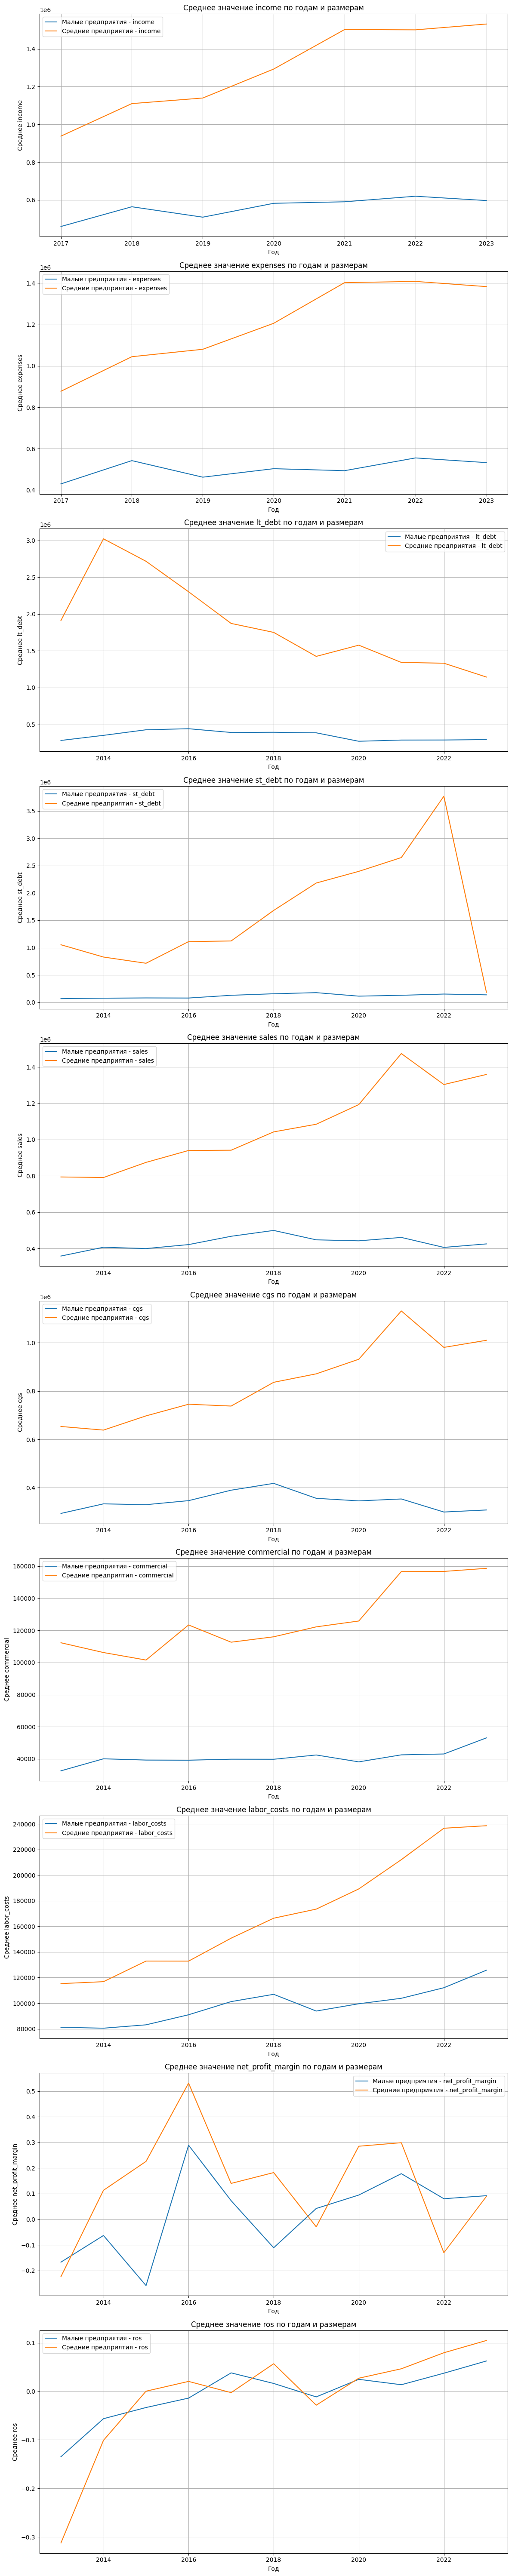

In [11]:
# Ensure all financial columns are numeric
for col in financial_columns:
    df_msp[col] = pd.to_numeric(df_msp[col], errors='coerce')

# 6. Расчет статистик для ВСЕХ финансовых показателей
financial_stats = calculate_yearly_stats(groups_year_size, financial_columns)

# 7. Добавление p-value (сравнение размеров *внутри каждого года* и *для каждого показателя*)
for year in financial_stats['Год'].unique():
    year_data = financial_stats[financial_stats['Год'] == year]
    if len(year_data) > 1:
        small_data = year_data[year_data['Размер'] == 'Малые предприятия']
        medium_data = year_data[year_data['Размер'] == 'Средние предприятия']
      
        if small_data.empty or medium_data.empty:
          continue

        # Сравниваем средние для каждого показателя
        p_values = []
        for col in financial_columns:
            small_mean = small_data[f'{col}_Среднее']
            medium_mean = medium_data[f'{col}_Среднее']
          
            if small_mean.isna().all() or medium_mean.isna().all():  # Если все значения NaN для столбца
                p_values.append(np.nan) # то и p-value = NaN
                continue  # Пропускаем этот столбец
                
            t_stat, p_value = stats.ttest_ind(small_mean.astype(float), medium_mean.astype(float), equal_var=False, nan_policy='omit')
            p_values.append(p_value)

        # Находим минимальное p-value среди всех показателей
        min_p_value = np.nanmin(p_values) if p_values else np.nan

         # Записываем МИНИМАЛЬНОЕ p-value
        financial_stats.loc[(financial_stats['Год'] == year) & (financial_stats['Размер'] == 'Средние предприятия'), 'p-value'] = min_p_value


# 8. Вывод статистической таблицы (пример для нескольких столбцов)
print("Статистическая таблица (часть):")
print(financial_stats.head(20).to_string())  # Выводим первые 20 строк для примера

# 9. Вывод ПОЛНОЙ таблицы в файл (чтобы не загромождать вывод)
with open('financial_stats_full.txt', 'w') as f:
    f.write(financial_stats.to_string())
print("\nПолная таблица записана в файл 'financial_stats_full.txt'")


# 10. Визуализация (пример: lineplot для income и equity)
fig, axes = plt.subplots(nrows=len(financial_columns), ncols=1, figsize=(12, 6 * len(financial_columns)))

if len(financial_columns) == 1:
    axes = [axes]

for i, col in enumerate(financial_columns):
    ax = axes[i]
    for size in financial_stats['Размер'].unique():
        size_data = financial_stats[financial_stats['Размер'] == size]
        ax.plot(size_data['Год'], size_data[f'{col}_Среднее'], label=f'{size} - {col}')

    ax.set_title(f'Среднее значение {col} по годам и размерам')
    ax.set_xlabel('Год')
    ax.set_ylabel(f'Среднее {col}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Ensure the column names are correct
if 'firts_number_okved' in df.columns and 'Технология' in df.columns:
    # Convert 'first_number_okved' to string if it's not already
    df['firts_number_okved'] = df['firts_number_okved'].astype(str)
    
    # Split the 'Технология' column by commas and explode the dataframe
    df_exploded = df.assign(Технология=df['Технология'].str.split(',')).explode('Технология')
    
    # Группировка по first_number_okved и Технология
    technology_popularity = df_exploded.groupby(['firts_number_okved', 'Технология']).size().reset_index(name='counts')

    # Сортировка по first_number_okved и количеству технологий
    technology_popularity = technology_popularity.sort_values(by=['firts_number_okved', 'counts'], ascending=[True, False])

    # Получение самой популярной технологии для каждого ОКВЭД
    most_popular_technology = technology_popularity.groupby('firts_number_okved').first().reset_index()

    # Выводим результат
    print(most_popular_technology)
else:
    print("One or both columns 'firts_number_okved' and 'Технология' do not exist in the DataFrame.")
    # Создание таблички с самой популярной технологией для каждого ОКВЭД
most_popular_technology_pivot = most_popular_technology.pivot(index='firts_number_okved', columns='Технология', values='counts').fillna(0)

most_popular_technology_pivot = most_popular_technology_pivot.sort_index()

# Создаем пустой DataFrame для хранения результатов
result_df = pd.DataFrame(index=["ОКВЭД", "Самая популярная технология", "Количество"])

# Заполняем DataFrame
for okved in most_popular_technology_pivot.index:
    most_used_technology = most_popular_technology_pivot.loc[okved].idxmax()
    count = most_popular_technology_pivot.loc[okved].max()
    
    # Добавляем данные в DataFrame
    result_df[okved] = [okved, most_used_technology, count]

# Выводим результат
result_df

   firts_number_okved       Технология  counts
0                 1.0             SaaS       4
1                10.0             SaaS      23
2                11.0             SaaS       3
3                13.0              CRM       1
4                14.0             SaaS       5
..                ...              ...     ...
62               85.0  ИБ - Антивирусы       1
63               86.0             SaaS       4
64                9.0              BPM       1
65               90.0              BPM       1
66               93.0             SaaS       3

[67 rows x 3 columns]


,1.0,10.0,11.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,79.0,8.0,80.0,81.0,82.0,85.0,86.0,9.0,90.0,93.0
ОКВЭД,1.0,10.0,11.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,79.0,8.0,80.0,81.0,82.0,85.0,86.0,9.0,90.0,93.0
Самая популярная технология,SaaS,SaaS,SaaS,CRM,SaaS,SaaS,SaaS,SaaS,SaaS,BPM,...,СЭД,BPM,SaaS,СЭД,SaaS,ИБ - Антивирусы,SaaS,BPM,BPM,SaaS
Количество,4.0,23.0,3.0,1.0,5.0,1.0,2.0,4.0,4.0,1.0,...,2.0,1.0,3.0,2.0,5.0,1.0,4.0,1.0,1.0,3.0


<Figure size 1200x800 with 0 Axes>

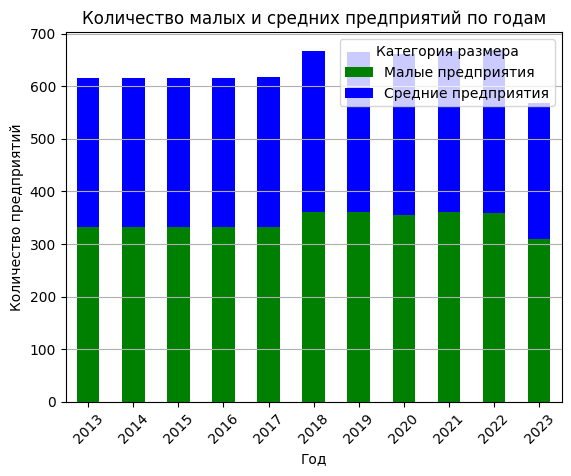

In [ ]:
# Группировка данных по годам и категориям размера
size_counts_by_year = df_msp.groupby(['year', 'size_cat']).size().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
size_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество малых и средних предприятий по годам')
plt.xlabel('Год')
plt.ylabel('Количество предприятий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()

C:\Users\Home\AppData\Local\Temp\ipykernel_22724\2843854898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')


<Figure size 1200x800 with 0 Axes>

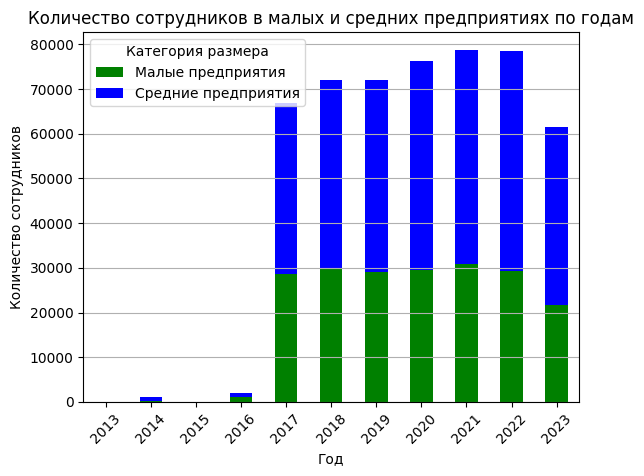

In [22]:
# Ensure 'employees' column is numeric
df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')

# Группировка данных по годам и категориям размера
employees_counts_by_year = df_msp.groupby(['year', 'size_cat'])['employees'].sum().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
employees_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество сотрудников в малых и средних предприятиях по годам')
plt.xlabel('Год')
plt.ylabel('Количество сотрудников')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()